In [1]:
train_model = False

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mls import mls
import json
from pathlib import Path

In [3]:
train_dataset = mls.CustomDataSet("./dataset/processed/train_data.csv")
val_dataset = mls.CustomDataSet("./dataset/processed/test_data.csv")

In [4]:
batch_size = 16
shuffle_dataset = True
num_epochs = 150
in_features = len(train_dataset[0][0])
out_classes = 5
save_model = True
save_interval = 10
model_p = './checkpoints2/'
Path(model_p).mkdir(parents=True, exist_ok=True)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [6]:
model = mls.MVC(in_features).double()
learning_rate = 0.1
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [7]:
if train_model:
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    lrs = []
    best_loss = np.inf
    for epoch in range(num_epochs):
        t_loss, t_acc = mls.training_epoch(model, optimizer, loss_f, train_loader)
        t_loss = t_loss/len(train_dataset)
        t_acc = 100*(t_acc/len(train_dataset))
        
        v_loss, v_acc = mls.validation_epoch(model, loss_f, validation_loader)
        v_loss = v_loss/len(val_dataset)
        v_acc = 100*(v_acc/len(val_dataset))
        
        train_loss.append(t_loss)
        val_loss.append(v_loss)
        train_acc.append(t_acc)
        val_acc.append(v_acc)
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step(v_loss)
        
        if epoch%save_interval==0 and save_model:
            isBest = v_loss<best_loss
            mls.save_model(model_p, epoch, model, optimizer, v_loss, isBest) 
            
        print(f'e{epoch}: Train Loss: {t_loss:.04f}; Val Loss: {v_loss:.04f} acc: {v_acc:.04f}')
    isBest = v_loss<best_loss
    mls.save_model(model_p, epoch, model, optimizer, v_loss, isBest) 

e0: Train Loss: 0.4939; Val Loss: 0.2432 acc: 91.4267
e1: Train Loss: 0.2207; Val Loss: 0.2821 acc: 89.9600
e2: Train Loss: 0.1908; Val Loss: 0.1817 acc: 93.5733
e3: Train Loss: 0.1713; Val Loss: 0.1795 acc: 93.6667
e4: Train Loss: 0.1613; Val Loss: 0.1745 acc: 93.6800
e5: Train Loss: 0.1523; Val Loss: 0.1573 acc: 94.2400
e6: Train Loss: 0.1447; Val Loss: 0.2350 acc: 91.5467
e7: Train Loss: 0.1365; Val Loss: 0.1530 acc: 94.2400
e8: Train Loss: 0.1287; Val Loss: 0.1420 acc: 94.6933
e9: Train Loss: 0.1211; Val Loss: 0.1787 acc: 93.5467
e10: Train Loss: 0.1153; Val Loss: 0.1345 acc: 94.9867
e11: Train Loss: 0.1076; Val Loss: 0.1517 acc: 94.5333
e12: Train Loss: 0.0999; Val Loss: 0.1280 acc: 95.3333
e13: Train Loss: 0.0919; Val Loss: 0.1533 acc: 94.6933
e14: Train Loss: 0.0889; Val Loss: 0.1221 acc: 95.7333
e15: Train Loss: 0.0812; Val Loss: 0.1205 acc: 95.5067
e16: Train Loss: 0.0786; Val Loss: 0.1238 acc: 95.7867
e17: Train Loss: 0.0746; Val Loss: 0.1276 acc: 95.8667
e18: Train Loss: 0.0

In [8]:
if train_model:
    with open(f'{model_p}/log.json', 'w') as fout:
        training_info ={
            'train_loss':train_loss,
            'train_acc':train_acc,
            'val_loss':val_loss,
            'val_acc':val_acc,
            'lrs':lrs,
        }
        json_dumps_str = json.dumps(training_info, indent=4)
        print(json_dumps_str, file=fout)
else:
    training_info = json.load(open(f'{model_p}/log.json'))
    train_loss = training_info['train_loss']
    train_acc = training_info['train_acc']
    val_loss = training_info['val_loss']
    val_acc = training_info['val_acc']
    lrs = training_info['lrs']

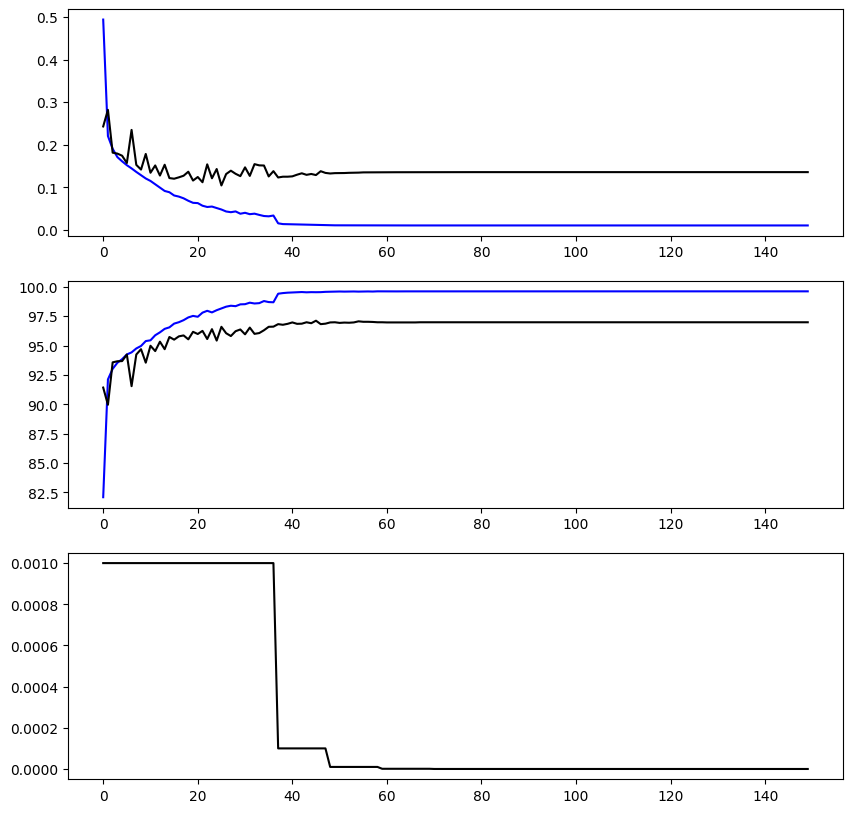

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(train_loss, color='blue')
axs[0].plot(val_loss, color='black')

axs[1].plot(train_acc, color='blue')
axs[1].plot(val_acc, color='black')

axs[2].plot(lrs, color='black')